# Starbucks Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.


### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploratory Data Analysis

**EDA on Portfolio**

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [6]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [7]:
portfolio.groupby(by="offer_type")['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [8]:
portfolio['difficulty'].unique()

array([10,  0,  5, 20,  7])

**EDA on profile**

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [10]:
profile.shape

(17000, 5)

In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [13]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [14]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [16]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [17]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [18]:
profile[profile['age']==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

**EDA on transcript**

In [19]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [20]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [21]:
transcript.shape

(306534, 4)

In [22]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [23]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [24]:
transcript.columns.duplicated().sum()

0

In [25]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [26]:
transcript['time'].unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [27]:
df_transaction=transcript[transcript['event']=="transaction"]

In [28]:
df_transaction

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}
12678,transaction,629fc02d56414d91bca360decdfa9288,0,{'amount': 33.9}
12686,transaction,bbeb54e861614fc7b22a8844f72dca6c,0,{'amount': 0.22}
12687,transaction,a97e6f33219c432db82acfa0d19c602d,0,{'amount': 18.59}
12691,transaction,676506bad68e4161b9bbaffeb039626b,0,{'amount': 18.01}
12696,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'amount': 19.11}


# Data Pre-processing

**Data Preprocessing** for portfolio

In [29]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [30]:
#rename id to offer_id
portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [31]:
#convert duration from days to hours
portfolio['duration']=portfolio['duration'].apply(lambda x: x*24)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [32]:
#rename duration to duration_h
portfolio.rename(columns={'duration':'duration_h'},inplace=True)

In [33]:
#one hot encoding for channels
portfolio['channel_email']=portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['channel_mobile']=portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['channel_social']=portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['channel_web']=portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [34]:
portfolio.loc[portfolio['offer_type'] == 'bogo', 'offer_type'] = 1
portfolio.loc[portfolio['offer_type'] == 'discount', 'offer_type'] = 2
portfolio.loc[portfolio['offer_type'] == 'informational', 'offer_type'] = 3

In [35]:
portfolio.drop(labels='channels',axis=1,inplace=True)

In [36]:
portfolio

,difficulty,duration_h,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,1,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,3,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,5,1,0,0,1
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,2,3,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,2,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,3,0,1,1,1,0
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,1,5,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,2,1,1,0,1


In [37]:
#normalize difficulty and reward columns with minmax scalar
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
x=['difficulty','reward']
portfolio[x]  = scaler.fit_transform(portfolio[x])

In [38]:
portfolio

,difficulty,duration_h,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,0.50,168,ae264e3637204a6fb9bb56bc8210ddfd,1,1.0,1,1,1,0
1,0.50,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1.0,1,1,1,1
2,0.00,96,3f207df678b143eea3cee63160fa8bed,3,0.0,1,1,0,1
3,0.25,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0.5,1,1,0,1
4,1.00,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,0.5,1,0,0,1
5,0.35,168,2298d6c36e964ae4a3e7e9706d1fb8c2,2,0.3,1,1,1,1
6,0.50,240,fafdcd668e3743c1bb461111dcafc2a4,2,0.2,1,1,1,1
7,0.00,72,5a8bc65990b245e5a138643cd4eb9837,3,0.0,1,1,1,0
8,0.25,120,f19421c1d4aa40978ebb69ca19b0e20d,1,0.5,1,1,1,1
9,0.50,168,2906b810c7d4411798c6938adc9daaa5,2,0.2,1,1,0,1


In [39]:
#transformation for offer id
labels_offer_id = portfolio['offer_id'].astype('category').cat.categories.tolist()
replace_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}

In [40]:
replace_offer_id

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
  '2298d6c36e964ae4a3e7e9706d1fb8c2': 2,
  '2906b810c7d4411798c6938adc9daaa5': 3,
  '3f207df678b143eea3cee63160fa8bed': 4,
  '4d5c57ea9a6940dd891ad53e9dbe8da0': 5,
  '5a8bc65990b245e5a138643cd4eb9837': 6,
  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7,
  'ae264e3637204a6fb9bb56bc8210ddfd': 8,
  'f19421c1d4aa40978ebb69ca19b0e20d': 9,
  'fafdcd668e3743c1bb461111dcafc2a4': 10}}

In [41]:
portfolio.replace(replace_offer_id, inplace=True)

In [42]:
portfolio

,difficulty,duration_h,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,0.50,168,8,1,1.0,1,1,1,0
1,0.50,120,5,1,1.0,1,1,1,1
2,0.00,96,4,3,0.0,1,1,0,1
3,0.25,168,7,1,0.5,1,1,0,1
4,1.00,240,1,2,0.5,1,0,0,1
5,0.35,168,2,2,0.3,1,1,1,1
6,0.50,240,10,2,0.2,1,1,1,1
7,0.00,72,6,3,0.0,1,1,1,0
8,0.25,120,9,1,0.5,1,1,1,1
9,0.50,168,3,2,0.2,1,1,0,1


**Data Processing on Profile**

In [43]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [44]:
#rename id to customer_id
profile.rename(columns={'id':'customer_id'},inplace=True)

In [45]:
#rearrange columns
profile=profile.reindex(columns=['customer_id', 'age','became_member_on','gender','income'])

In [46]:
#transform cust id similar as offer id
labels_cus_id = profile['customer_id'].astype('category').cat.categories.tolist()
replace_cus_id = {'customer_id' : {k: v for k,v in zip(labels_cus_id,list(range(1,len(labels_cus_id)+1)))}}
profile.replace(replace_cus_id, inplace=True)

In [47]:
profile

,customer_id,age,became_member_on,gender,income
0,6962,118,20170212,None,NaN
1,399,55,20170715,F,112000.0
2,3747,118,20180712,None,NaN
3,7997,75,20170509,F,100000.0
4,10736,118,20170804,None,NaN
5,15044,68,20180426,M,70000.0
6,9525,118,20170925,None,NaN
7,6940,118,20171002,None,NaN
8,3729,65,20180209,M,53000.0
9,9147,118,20161122,None,NaN


In [48]:
#replace age 118 with nan
profile['age']=profile['age'].apply(lambda x: np.nan if x==118 else x)

In [49]:
#drop values with nan in age income gender
profile=profile.dropna()

In [50]:
profile.isnull().sum()

customer_id         0
age                 0
became_member_on    0
gender              0
income              0
dtype: int64

In [51]:
profile['age'].dtype

dtype('float64')

In [52]:
#change float to int for age and income
profile = profile.astype({"age": int, "income": int})

In [53]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
customer_id         14825 non-null int64
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
income              14825 non-null int64
dtypes: int64(4), object(1)
memory usage: 694.9+ KB


In [54]:
x=profile['age'].unique()

In [55]:
#create new column grouped wiith age group
profile['age_group']=pd.cut(profile['age'],bins=[17,22,35,60,103],labels=['teenager','young-adult','adult','elderly'])

In [56]:
x=profile['age_group'].astype('category').cat.categories.tolist()

In [57]:
y={"age_group": {k:v for k,v in zip(x,list(range(1,len(x)+1)))}}

In [58]:
profile.replace(y,inplace=True)

In [59]:
profile.drop(columns="age",inplace=True)

In [60]:
profile

,customer_id,became_member_on,gender,income,age_group
1,399,20170715,F,112000,3
3,7997,20170509,F,100000,4
5,15044,20180426,M,70000,4
8,3729,20180209,M,53000,4
12,3060,20171111,M,51000,3
13,11411,20170911,F,57000,4
14,14985,20140213,M,46000,2
15,3275,20160211,F,71000,4
16,6547,20141113,M,52000,3
18,6657,20171231,M,42000,3


In [61]:
#create new column income range
profile['income_range']=pd.cut(profile['income'],bins=[29999,60000,90000,120001],labels=['average','above_average','high'])

In [62]:
profile['income_range'].head()

1              high
3              high
5     above_average
8           average
12          average
Name: income_range, dtype: category
Categories (3, object): [average < above_average < high]

In [63]:
profile=profile.drop(columns="income")

In [64]:
profile

,customer_id,became_member_on,gender,age_group,income_range
1,399,20170715,F,3,high
3,7997,20170509,F,4,high
5,15044,20180426,M,4,above_average
8,3729,20180209,M,4,average
12,3060,20171111,M,3,average
13,11411,20170911,F,4,average
14,14985,20140213,M,2,average
15,3275,20160211,F,4,above_average
16,6547,20141113,M,3,average
18,6657,20171231,M,3,average


In [65]:
labels=profile['income_range'].astype('category').cat.categories.tolist()

In [66]:
x={'income_range':{k:v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

In [67]:
profile.replace(x,inplace=True)

In [68]:
profile

,customer_id,became_member_on,gender,age_group,income_range
1,399,20170715,F,3,3
3,7997,20170509,F,4,3
5,15044,20180426,M,4,2
8,3729,20180209,M,4,1
12,3060,20171111,M,3,1
13,11411,20170911,F,4,1
14,14985,20140213,M,2,1
15,3275,20160211,F,4,2
16,6547,20141113,M,3,1
18,6657,20171231,M,3,1


In [69]:
#gender to 1 2 3
labels=profile['gender'].astype('category').cat.categories.tolist()

In [70]:
x={'gender':{k:v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

In [71]:
profile.replace(x,inplace=True)

In [72]:
profile['became_member_on']=pd.to_datetime(profile['became_member_on'],format='%Y%m%d')

In [73]:
profile['became_member_on']

1       2017-07-15
3       2017-05-09
5       2018-04-26
8       2018-02-09
12      2017-11-11
13      2017-09-11
14      2014-02-13
15      2016-02-11
16      2014-11-13
18      2017-12-31
19      2018-05-01
20      2016-05-04
21      2017-09-09
22      2017-06-16
24      2013-08-11
25      2018-04-28
27      2017-09-26
28      2017-09-11
29      2015-01-21
30      2014-08-23
31      2017-09-16
32      2017-09-25
33      2017-11-17
34      2016-07-09
35      2016-08-14
37      2014-05-11
38      2017-08-12
40      2015-11-12
41      2016-07-11
42      2018-07-07
           ...    
16963   2017-01-12
16964   2018-04-08
16965   2018-04-09
16966   2015-01-26
16967   2015-06-26
16968   2017-07-25
16970   2015-11-07
16971   2018-05-22
16972   2017-01-19
16973   2015-10-12
16974   2016-01-13
16975   2017-12-31
16976   2016-09-21
16978   2017-02-20
16979   2013-09-22
16981   2016-06-29
16983   2015-04-04
16984   2016-07-16
16985   2018-06-19
16986   2017-07-31
16987   2016-07-09
16988   2018

In [74]:
profile['membership_year']=pd.to_datetime(profile['became_member_on']).dt.year

In [75]:
profile['membership_year']

1        2017
3        2017
5        2018
8        2018
12       2017
13       2017
14       2014
15       2016
16       2014
18       2017
19       2018
20       2016
21       2017
22       2017
24       2013
25       2018
27       2017
28       2017
29       2015
30       2014
31       2017
32       2017
33       2017
34       2016
35       2016
37       2014
38       2017
40       2015
41       2016
42       2018
         ... 
16963    2017
16964    2018
16965    2018
16966    2015
16967    2015
16968    2017
16970    2015
16971    2018
16972    2017
16973    2015
16974    2016
16975    2017
16976    2016
16978    2017
16979    2013
16981    2016
16983    2015
16984    2016
16985    2018
16986    2017
16987    2016
16988    2018
16990    2016
16992    2017
16993    2018
16995    2018
16996    2018
16997    2017
16998    2016
16999    2017
Name: membership_year, Length: 14825, dtype: int64

In [76]:
import datetime
profile['membership_days']=datetime.datetime.today().date() - profile['became_member_on'].dt.date

In [77]:
profile['membership_days']=profile['membership_days'].dt.days

In [78]:
profile

,customer_id,became_member_on,gender,age_group,income_range,membership_year,membership_days
1,399,2017-07-15,1,3,3,2017,1042
3,7997,2017-05-09,1,4,3,2017,1109
5,15044,2018-04-26,2,4,2,2018,757
8,3729,2018-02-09,2,4,1,2018,833
12,3060,2017-11-11,2,3,1,2017,923
13,11411,2017-09-11,1,4,1,2017,984
14,14985,2014-02-13,2,2,1,2014,2290
15,3275,2016-02-11,1,4,2,2016,1562
16,6547,2014-11-13,2,3,1,2014,2017
18,6657,2017-12-31,2,3,1,2017,873


In [79]:
profile['membership_days'].describe()

count    14825.000000
mean      1188.478988
std        419.205158
min        666.000000
25%        874.000000
50%       1024.000000
75%       1463.000000
max       2489.000000
Name: membership_days, dtype: float64

In [80]:
profile['member_type']=pd.cut(profile['membership_days'],bins=[665,1199,1999,2488],labels=['new','regular','loyal'])

In [81]:
x=profile['member_type'].astype('category').cat.categories.tolist()

In [82]:
y={'member_type':{k:v for k,v in zip(x,list(range(1,len(x)+1)))}}

In [83]:
profile.replace(y,inplace=True)

In [84]:
#to int64
profile['member_type'] = profile['member_type'].values.astype(np.int64)


In [85]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 8 columns):
customer_id         14825 non-null int64
became_member_on    14825 non-null datetime64[ns]
gender              14825 non-null int64
age_group           14825 non-null int64
income_range        14825 non-null int64
membership_year     14825 non-null int64
membership_days     14825 non-null int64
member_type         14825 non-null int64
dtypes: datetime64[ns](1), int64(7)
memory usage: 1.0 MB


In [86]:
profile.drop(columns=['membership_days','became_member_on'],inplace=True)

In [87]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
customer_id        14825 non-null int64
gender             14825 non-null int64
age_group          14825 non-null int64
income_range       14825 non-null int64
membership_year    14825 non-null int64
member_type        14825 non-null int64
dtypes: int64(6)
memory usage: 810.7 KB


**Data processing on transcript**

In [88]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [89]:
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [90]:
#rename time to time_h
transcript.rename(columns={'time':'time_h'},inplace=True)

In [91]:
#rename person to customer_id
transcript.rename(columns={'person':'customer_id'},inplace=True)

In [92]:
#all customers to 1 2 3 4...
x=transcript['customer_id'].astype('category').cat.categories.tolist()

In [93]:
y={'customer_id':{k:v for k,v in zip(x,list(range(1,len(x)+1)))}}

In [94]:
transcript.replace(y,inplace=True)

In [95]:
transcript

,event,customer_id,time_h,value
0,offer received,7997,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,10736,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,15044,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,9525,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,6940,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,3729,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,13109,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,3060,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,11411,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,3275,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [96]:
#value column extract values like offer id, amount, reward, offer_id
'''keys=[]
for idx,row in transcript.iterrows():
    for rows in transcript['value']:
        if rows in keys:
            continue
        else:
            keys.append(rows)
keys'''

"keys=[]\nfor idx,row in transcript.iterrows():\n    for rows in transcript['value']:\n        if rows in keys:\n            continue\n        else:\n            keys.append(rows)\nkeys"

In [97]:
transcript['offer_id']=''
transcript['amount']=0

transcript['reward']=0

In [98]:
#put offerid amount and reward in respective column
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward'] = row['value'][k]

In [99]:
#put nan where NA is in offerid'
transcript['offer_id']=transcript['offer_id'].apply(lambda x: 'N/A' if x == '' else x)

In [100]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
event          306534 non-null object
customer_id    306534 non-null int64
time_h         306534 non-null int64
value          306534 non-null object
offer_id       306534 non-null object
amount         306534 non-null int64
reward         306534 non-null int64
dtypes: int64(4), object(3)
memory usage: 16.4+ MB


In [101]:
transcript['offer_id']

0         9b98b8c7a33c4b65b9aebfe6a799e6d9
1         0b1e1539f2cc45b7b9fa7c272da2e1d7
2         2906b810c7d4411798c6938adc9daaa5
3         fafdcd668e3743c1bb461111dcafc2a4
4         4d5c57ea9a6940dd891ad53e9dbe8da0
5         f19421c1d4aa40978ebb69ca19b0e20d
6         2298d6c36e964ae4a3e7e9706d1fb8c2
7         3f207df678b143eea3cee63160fa8bed
8         0b1e1539f2cc45b7b9fa7c272da2e1d7
9         0b1e1539f2cc45b7b9fa7c272da2e1d7
10        0b1e1539f2cc45b7b9fa7c272da2e1d7
11        0b1e1539f2cc45b7b9fa7c272da2e1d7
12        ae264e3637204a6fb9bb56bc8210ddfd
13        3f207df678b143eea3cee63160fa8bed
14        0b1e1539f2cc45b7b9fa7c272da2e1d7
15        fafdcd668e3743c1bb461111dcafc2a4
16        0b1e1539f2cc45b7b9fa7c272da2e1d7
17        2906b810c7d4411798c6938adc9daaa5
18        9b98b8c7a33c4b65b9aebfe6a799e6d9
19        ae264e3637204a6fb9bb56bc8210ddfd
20        2906b810c7d4411798c6938adc9daaa5
21        9b98b8c7a33c4b65b9aebfe6a799e6d9
22        4d5c57ea9a6940dd891ad53e9dbe8da0
23        2

In [102]:
transcript['event']

0          offer received
1          offer received
2          offer received
3          offer received
4          offer received
5          offer received
6          offer received
7          offer received
8          offer received
9          offer received
10         offer received
11         offer received
12         offer received
13         offer received
14         offer received
15         offer received
16         offer received
17         offer received
18         offer received
19         offer received
20         offer received
21         offer received
22         offer received
23         offer received
24         offer received
25         offer received
26         offer received
27         offer received
28         offer received
29         offer received
               ...       
306504        transaction
306505        transaction
306506    offer completed
306507       offer viewed
306508        transaction
306509    offer completed
306510        transaction
306511      

In [103]:
# we dont want values with transaction and offer recieved
transcript['event']=transcript[transcript['event'] != 'transaction']
transcript['event']=transcript[transcript['event'] != 'offer received']

In [104]:
transcript['event']

0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
5                     NaN
6                     NaN
7                     NaN
8                     NaN
9                     NaN
10                    NaN
11                    NaN
12                    NaN
13                    NaN
14                    NaN
15                    NaN
16                    NaN
17                    NaN
18                    NaN
19                    NaN
20                    NaN
21                    NaN
22                    NaN
23                    NaN
24                    NaN
25                    NaN
26                    NaN
27                    NaN
28                    NaN
29                    NaN
               ...       
306504                NaN
306505                NaN
306506    offer completed
306507       offer viewed
306508                NaN
306509    offer completed
306510                NaN
306511      

In [105]:
x=transcript['event'].astype('category').cat.categories.tolist()
y={'event':{k:v  for k,v in zip(x,list(range(1,len(x)+1)))}}

In [106]:
#replace offer completed and viewed with 1 2
transcript.replace(y,inplace=True)

In [107]:
transcript

,event,customer_id,time_h,value,offer_id,amount,reward
0,NaN,7997,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,NaN,10736,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,NaN,15044,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0
3,NaN,9525,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,0
4,NaN,6940,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
5,NaN,3729,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,0,0
6,NaN,13109,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,0,0
7,NaN,3060,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,0,0
8,NaN,11411,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
9,NaN,3275,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0


In [108]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
event          91304 non-null float64
customer_id    306534 non-null int64
time_h         306534 non-null int64
value          306534 non-null object
offer_id       306534 non-null object
amount         306534 non-null int64
reward         306534 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 16.4+ MB


In [109]:
transcript['event']=transcript['event'].fillna(0).astype(int)

In [110]:
transcript.head()

,event,customer_id,time_h,value,offer_id,amount,reward
0,0,7997,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,0,10736,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,0,15044,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0
3,0,9525,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,0
4,0,6940,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [111]:
transcript.replace(replace_offer_id,inplace=True)

In [112]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
event          306534 non-null int64
customer_id    306534 non-null int64
time_h         306534 non-null int64
value          306534 non-null object
offer_id       306534 non-null object
amount         306534 non-null int64
reward         306534 non-null int64
dtypes: int64(5), object(2)
memory usage: 16.4+ MB


In [113]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio.head()

,difficulty,duration_h,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,0.50,168,8,1,1.0,1,1,1,0
1,0.50,120,5,1,1.0,1,1,1,1
2,0.00,96,4,3,0.0,1,1,0,1
3,0.25,168,7,1,0.5,1,1,0,1
4,1.00,240,1,2,0.5,1,0,0,1


In [114]:
transcript['offer_id']=transcript['offer_id'].apply(lambda x: 0 if x =='N/A' else x)
transcript['offer_id'].unique()

array([ 7,  1,  3, 10,  5,  9,  2,  4,  8,  6,  0])

In [115]:
transcript['offer_id'].unique()

array([ 7,  1,  3, 10,  5,  9,  2,  4,  8,  6,  0])

In [116]:
transcript.drop(transcript.index[transcript['event'] == 0],inplace=True)


# Merge datasets to master df 

In [117]:
#merge all three df
master_df=transcript.merge(portfolio,how="left",on="offer_id")
master_df=master_df.merge(profile,how="left",on="customer_id")
master_df.head()

,event,customer_id,time_h,value,offer_id,amount,reward_x,difficulty,duration_h,offer_type,reward_y,channel_email,channel_mobile,channel_social,channel_web,gender,age_group,income_range,membership_year,member_type
0,2,3729,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},9,0,0,0.25,120,1,0.5,1,1,1,1,2.0,4.0,1.0,2018.0,1.0
1,2,13995,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},6,0,0,0.00,72,3,0.0,1,1,1,0,3.0,3.0,1.0,2017.0,1.0
2,2,1052,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},5,0,0,0.50,120,1,1.0,1,1,1,1,1.0,4.0,1.0,2016.0,2.0
3,2,170,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},8,0,0,0.50,168,1,1.0,1,1,1,0,1.0,1.0,1.0,2016.0,2.0
4,2,12744,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},6,0,0,0.00,72,3,0.0,1,1,1,0,2.0,3.0,1.0,2014.0,3.0


# Data analysis on master dataset

In [118]:
from matplotlib import *
import pylab as plt
%matplotlib inline
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 0 to 91303
Data columns (total 20 columns):
event              91304 non-null int64
customer_id        91304 non-null int64
time_h             91304 non-null int64
value              91304 non-null object
offer_id           91304 non-null int64
amount             91304 non-null int64
reward_x           91304 non-null int64
difficulty         91304 non-null float64
duration_h         91304 non-null int64
offer_type         91304 non-null int64
reward_y           91304 non-null float64
channel_email      91304 non-null int64
channel_mobile     91304 non-null int64
channel_social     91304 non-null int64
channel_web        91304 non-null int64
gender             82304 non-null float64
age_group          82304 non-null float64
income_range       82304 non-null float64
membership_year    82304 non-null float64
member_type        82304 non-null float64
dtypes: float64(7), int64(12), object(1)
memory usage: 14.6+ MB


In [119]:
master_df.dropna(inplace=True)

In [120]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82304 entries, 0 to 91303
Data columns (total 20 columns):
event              82304 non-null int64
customer_id        82304 non-null int64
time_h             82304 non-null int64
value              82304 non-null object
offer_id           82304 non-null int64
amount             82304 non-null int64
reward_x           82304 non-null int64
difficulty         82304 non-null float64
duration_h         82304 non-null int64
offer_type         82304 non-null int64
reward_y           82304 non-null float64
channel_email      82304 non-null int64
channel_mobile     82304 non-null int64
channel_social     82304 non-null int64
channel_web        82304 non-null int64
gender             82304 non-null float64
age_group          82304 non-null float64
income_range       82304 non-null float64
membership_year    82304 non-null float64
member_type        82304 non-null float64
dtypes: float64(7), int64(12), object(1)
memory usage: 13.2+ MB


In [121]:
master_df.columns

Index(['event', 'customer_id', 'time_h', 'value', 'offer_id', 'amount',
       'reward_x', 'difficulty', 'duration_h', 'offer_type', 'reward_y',
       'channel_email', 'channel_mobile', 'channel_social', 'channel_web',
       'gender', 'age_group', 'income_range', 'membership_year',
       'member_type'],
      dtype='object')

In [122]:
master_df.rename(columns={'reward_x':'reward'},inplace=True)

In [123]:
#finding correlation between labels
corr=master_df.corr()

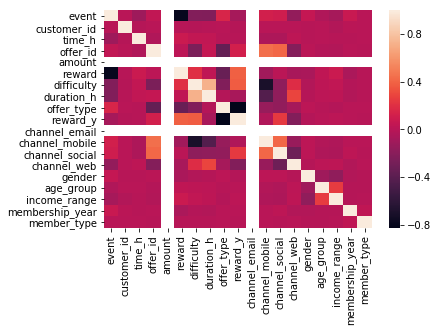

In [124]:
import seaborn as sns
sns.heatmap(corr)

# Data Modeling

In [125]:
#important features for training obtained from corr
X = master_df[['time_h','offer_id','amount','reward','difficulty','duration_h','offer_type','gender','age_group','income_range', 'member_type']]
Y = master_df['event']

In [126]:
#split train test
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [127]:
#function for checking accuracy
def predict_score(model):
    pred = model.predict(X_test)
    
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 4)

**1) Logistic Regression**

In [128]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(logreg)}%')

Accuracy of Logistic regression classifier on training set: 60.65%.
Prediction Accuracy: 60.3883%


**2) Random Forest Classifier**

In [129]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(rf.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(rf)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


**3) Support Vector Machine**

In [130]:
svm = SVC(gamma = 'auto')

svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(svm)}%')


Accuracy of SVM classifier on training set: 99.99%.
Prediction Accuracy: 99.9878%


**4) Decision Tree**

In [131]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


**5) Naive Bayes**

In [132]:
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
print(f'Accuracy of SVM classifier on training set: {round(gnb.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(gnb)}%')

Accuracy of SVM classifier on training set: 60.65%.
Prediction Accuracy: 60.3883%


**6) K nearest neighbors**

In [133]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(knn)}%')

Accuracy of K-NN classifier on training set: 99.91%.
Prediction Accuracy: 99.8712%


# Model evaluation

In [134]:
models = [svm, dt, gnb, knn, rf, logreg]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train)*100 for x in models]
predection_accuracy = [predict_score(y) for y in models]

In [135]:
results = [training_accuracy, predection_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 
results_df

,SVC,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier,RandomForestRegressor,LogisticRegression
Training Accuracy,99.99352,100.0,60.646708,99.914139,100.0,60.646708
Predicting Accuracy,99.98780,100.0,60.388300,99.871200,100.0,60.388300


# Model Refinement

These models are giving very good accuracy, however Naive Bayes and Logistic regression is not upto the mark. 
In addition to that, I think SVC DT and RF are overfitted because it is very close to 100. That's why I chose KNN model for further refinement with GridSearchCV (sklearn pipeline).

# Questions based on Data visualization

In [136]:
# reconverting the values of the following features from numerical values to its original categorical values.
master_df['event'] = master_df['event'].map({1: 'Completed', 2: 'Viewed'})
master_df['offer_type'] = master_df['offer_type'].map({1: 'BOGO', 2: 'Discount', 3: 'Informational'})
master_df['income_range'] = master_df['income_range'].map({1: 'Average', 2: 'Above-Average', 3:'High'})
master_df['age_group'] = master_df['age_group'].map({1: 'teenager', 2: 'young-adult', 3:'adult', 4:'elderly'})

**What is the common offer each age group ( teenagers, young-adults, adults and elderly)?**

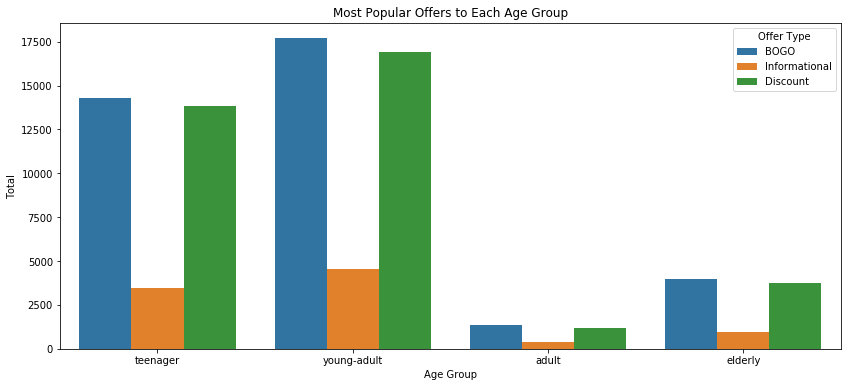

In [137]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="age_group", hue="offer_type", data=master_df)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
xlabels = ['teenager','young-adult','adult','elderly']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

The most common offer type among all age groups is the BOGO , followed by the Discount Offers. Whereas, the least common offer to be sent is the informational offers. I believe that BOGO offers are more attractive compared to other offers provided by Starbucks.

**Based on the demographic data of the customers who gets the highest income range , males or females?**

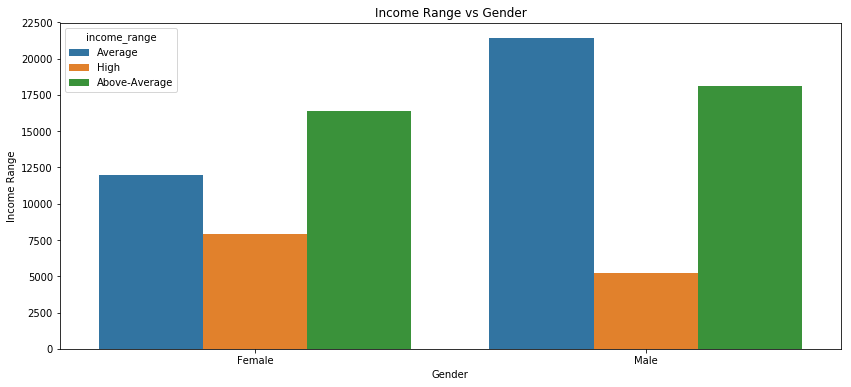

In [138]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="gender", hue="income_range", data= master_df[master_df["gender"] != 3])
plt.title('Income Range vs Gender')
plt.ylabel('Income Range')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

Customers with High income (Above 90,000) are mostly female customers. Whereas, Average Income(30,000 - 60,000) customers are mostly males.

**How many new members Starbucks got each year?**

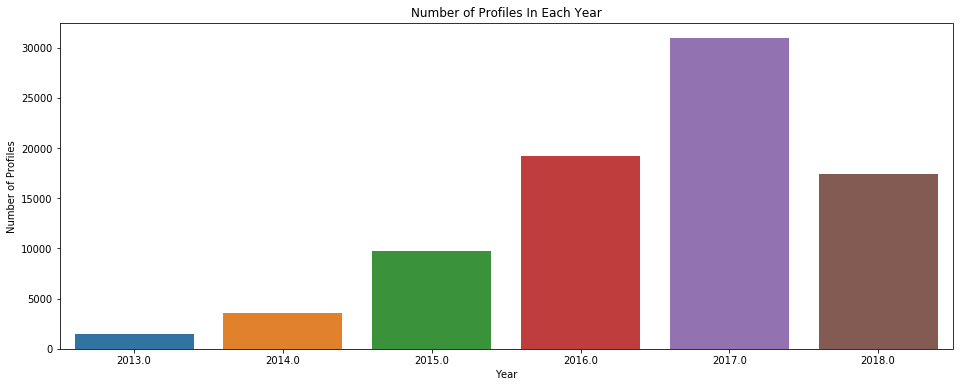

In [139]:
plt.figure(figsize=(16, 6))
sns.countplot(master_df['membership_year'])
plt.title('Number of Profiles In Each Year')
plt.ylabel('Number of Profiles')
plt.xlabel('Year')
plt.xticks()
plt.show();

2017 was the best year for Starbucks in terms of the number of new members.

**Which type of promotions(offers) each gender likes?**

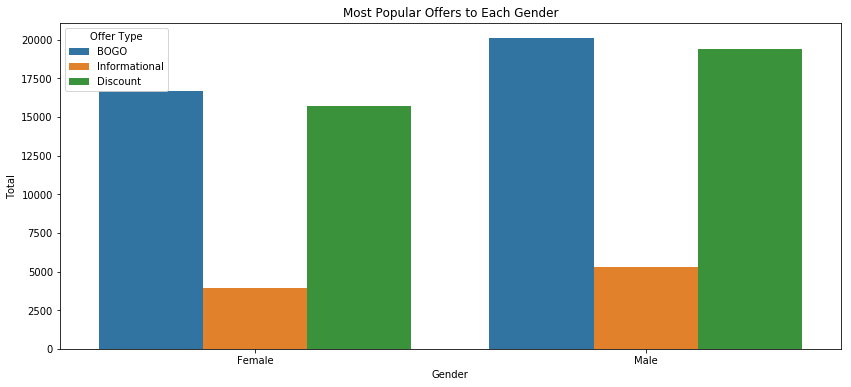

In [140]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="offer_type", data= master_df[master_df["gender"] != 3])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

Both genders liked BOGO and lest liked is Infomational offer.

**What is average time to complete offer?**

In [141]:
tran_avg_len = master_df.groupby(['customer_id', 'offer_id'])['time_h'].mean().reset_index()
tran_avg_len['time_h'].mean(), tran_avg_len['time_h'].mean() / 24

(372.24939705130396, 15.510391543804332)

The mean time it takes a customer to complete an offer is less than 16 days (372 hours).

**From all the offers the customers viewed , how many offers they completed?**

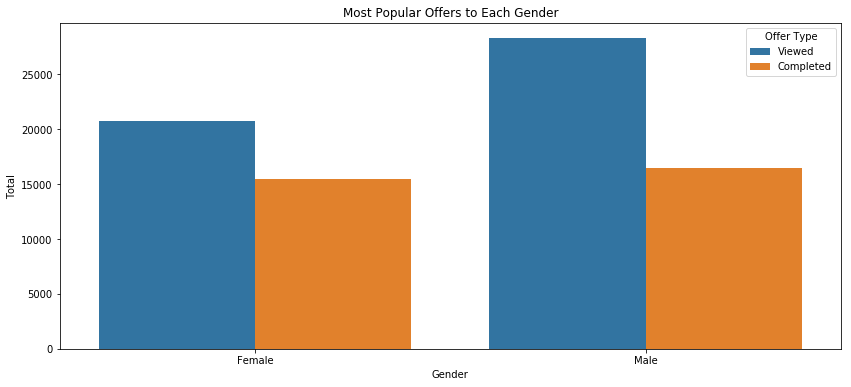

In [142]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="event", data= master_df[master_df["gender"] != 3])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

Females responded highly in terms of completing offer compared to male.

# Improvement

I believe I got to a point where I had very good results when it comes to the prediction model. I understood the data provided by Starbucks very well.

I believe that the idea of improving the data collection or fixing issues related with the missing data or NaNs would be really helpful. In my opinion, I think that we can get great insights from this data set and great prediction models might be also built to solve problems statemetns associated with this data set . Examples for these model are the following :

Building a model that can predict which kind of offers to be sent to which customer?
Building a model that can predict which customers would buy any way ( regardless if there is an offer or not)

# Reflection

I really enjoyed working on this project which allowed me to polish my skills in Data Preprocessing and Modeling. The most difficult part in my opinion was understanding data. 

The Preprocessing Step was the longest and most challanging part to complete. The Dataset itself is inspiring. Honestly,Everything was amazing.